In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# створення середовища
env = gym.make("Acrobot-v1") 
# render=gym.make("Acrobot-v1", render_mode="human")


# перевірка кількості дій
print("Кількість можливих дій:", env.action_space.n)
print("Форма спостереження (стану):", env.observation_space.shape)


Кількість можливих дій: 3
Форма спостереження (стану): (6,)


In [2]:
def create_bins(env, bins_per_dim):
    bins = []
    for i in range(len(env.observation_space.low)):
        low = env.observation_space.low[i]
        high = env.observation_space.high[i]

        # якщо межі нескінченні (а такі є в Acrobot), задаємо штучні
        if not np.isfinite(low) or not np.isfinite(high):
            low, high = -1.0, 1.0  # типове обмеження

        bin_edges = np.linspace(low, high, bins_per_dim + 1)[1:-1]
        bins.append(bin_edges)
    return bins

def discretize_state(state, bins):
    return tuple(np.digitize(s, b) for s, b in zip(state, bins))


In [3]:
# Кількість дискретних "відер" на кожну з 6 ознак стану
bins_per_dim = 10
bins = create_bins(env, bins_per_dim)

# Розміри Q-таблиці: (кількість відер + 1) ^ кількість вимірів стану × кількість дій
q_table = np.zeros([bins_per_dim + 1] * len(bins) + [env.action_space.n])

# Гіперпараметри
n_episodes = 10000          # кількість епізодів навчання
max_steps = 500           # макс. к-ть кроків в одному епізоді
alpha = 0.2               # швидкість навчання
gamma = 0.98              # коефіцієнт дисконтування
epsilon = 1.0             # стартовий рівень випадковості
epsilon_decay = 0.99     # як швидко зменшується ε
min_epsilon = 0.01        # мінімальне значення ε

rewards = []  # для збереження сумарних винагород


In [4]:
def choose_action(state, q_table, epsilon):
    if np.random.random() < epsilon:
        return np.random.randint(q_table.shape[-1])  # випадкова дія
    return np.argmax(q_table[state])  # найкраща дія

for episode in range(n_episodes):
    state, _ = env.reset()
    state_disc = discretize_state(state, bins)
    total_reward = 0

    for step in range(max_steps):
        action = choose_action(state_disc, q_table, epsilon)
        next_state, reward, done, truncated, _ = env.step(action)
        next_state_disc = discretize_state(next_state, bins)

        # Q-оновлення
        best_next = np.max(q_table[next_state_disc])
        q_table[state_disc][action] += alpha * (reward + gamma * best_next - q_table[state_disc][action])

        state_disc = next_state_disc
        total_reward += reward

        if done or truncated:
            break

    # зменшуємо epsilon (менше випадковості з часом)
    epsilon = max(min_epsilon, epsilon * epsilon_decay)
    rewards.append(total_reward)

    # лог кожні 10 епізодів
    if (episode + 1) % 10 == 0:
        print(f"Епізод {episode + 1:3d}: винагорода = {total_reward:.2f}, ε = {epsilon:.3f}")


Епізод  10: винагорода = -500.00, ε = 0.904
Епізод  20: винагорода = -500.00, ε = 0.818
Епізод  30: винагорода = -500.00, ε = 0.740
Епізод  40: винагорода = -500.00, ε = 0.669
Епізод  50: винагорода = -500.00, ε = 0.605
Епізод  60: винагорода = -500.00, ε = 0.547
Епізод  70: винагорода = -500.00, ε = 0.495
Епізод  80: винагорода = -500.00, ε = 0.448
Епізод  90: винагорода = -500.00, ε = 0.405
Епізод 100: винагорода = -500.00, ε = 0.366
Епізод 110: винагорода = -500.00, ε = 0.331
Епізод 120: винагорода = -500.00, ε = 0.299
Епізод 130: винагорода = -392.00, ε = 0.271
Епізод 140: винагорода = -500.00, ε = 0.245
Епізод 150: винагорода = -500.00, ε = 0.221
Епізод 160: винагорода = -500.00, ε = 0.200
Епізод 170: винагорода = -271.00, ε = 0.181
Епізод 180: винагорода = -330.00, ε = 0.164
Епізод 190: винагорода = -500.00, ε = 0.148
Епізод 200: винагорода = -500.00, ε = 0.134
Епізод 210: винагорода = -500.00, ε = 0.121
Епізод 220: винагорода = -500.00, ε = 0.110
Епізод 230: винагорода = -500.00

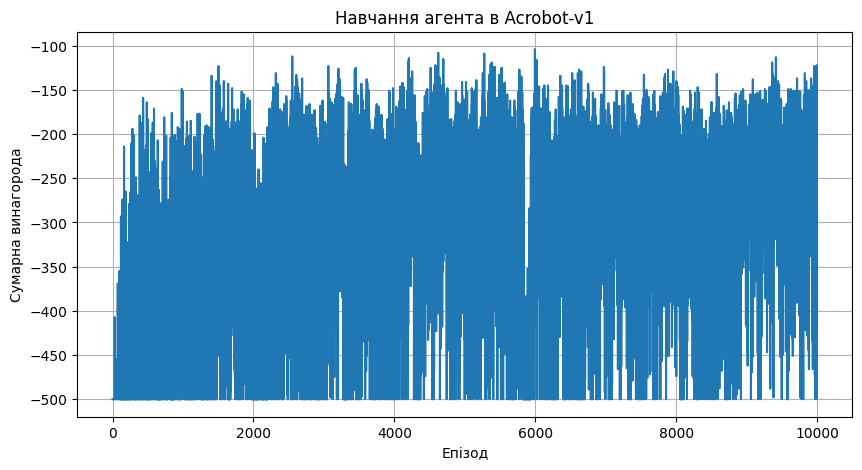

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(rewards)
plt.xlabel("Епізод")
plt.ylabel("Сумарна винагорода")
plt.title("Навчання агента в Acrobot-v1")
plt.grid(True)
plt.show()


In [7]:
import gymnasium as gym
import time
import numpy as np

env = gym.make("Acrobot-v1", render_mode="human")

obs, _ = env.reset()
done = False

for step in range(500):
    state = discretize_state(obs, bins)  # ← ось правильна функція
    action = np.argmax(q_table[state])   # q_table — твоя навчена таблиця
    obs, reward, terminated, truncated, _ = env.step(action)

    if terminated or truncated:
        break

    time.sleep(0.02)

env.close()
